* This notebook was made to check the salt, total and fresh water flux at transect 4 (at the river mouth) and the investigate the sensitivity of choice of S0.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools,rivertools)
import datetime, os
from glob import glob
import matplotlib.pyplot as plt
from R_mixStuff import sites
from R_mixStuff import strings
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

In [2]:
transects = {'1':{'jst':55, 'ist':25,'jen':56,'ien':80},
            '2':{'jst':25, 'ist':25,'jen':26,'ien':75},
            '3':{'jst':25, 'ist':25,'jen':56,'ien':26},
            '4':{'jst':37, 'ist':72,'jen':45,'ien':73},
            '5':{'jst':120, 'ist':138,'jen':121,'ien':139},
            '6':{'jst':96,'ist':125,'jen':97,'ien':126},
            '7':{'jst':36,'ist':98,'jen':37,'ien':99}}
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][380:510,240:397]
Y = grid6.variables['nav_lat'][380:510,240:397]
bathy = grid6.variables['Bathymetry'][380:510,240:397]

In [3]:
## mask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
umask = mesh.variables['umask'][0,:,380:510,240:397]
vmask = mesh.variables['vmask'][0,:,380:510,240:397]
e3u = mesh.variables['e3u'][0,:,380:510,240:397]
e3v = mesh.variables['e3v'][0,:,380:510,240:397]
e3t = mesh.variables['e3t'][0,:,380:510,240:397]
e2t = mesh.variables['e2t'][0,380:510,240:397]
e1t = mesh.variables['e1t'][0,380:510,240:397]
np_mask = np.abs(1-tmask) 

(48.95, 49.7)

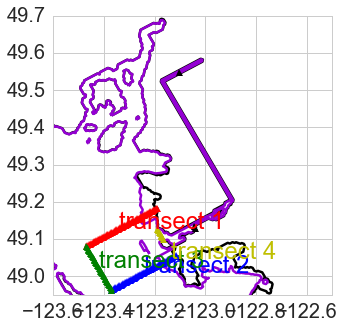

In [4]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
ax.plot(X[55,25:80],Y[55,25:80],'r^')
ax.plot(X[25,25:75],Y[25,25:75],'b^')
ax.plot(X[25:56,25],Y[25:56,25],'g^')
ax.plot(X[37:45,72],Y[37:45,72],'y^')
ax.plot(X[34:36,94],Y[34:36,94],'k^')
ax.plot(X[120:121,138],Y[120:121,138],'k^')
ax.annotate ('transect 1',(X[55,50],Y[55,50]), xycoords="data",color = 'r')
ax.annotate ('transect 2',(X[25,50],Y[25,50]), xycoords="data",color = 'b')
ax.annotate ('transect 3',(X[40,25],Y[40,25]), xycoords="data",color = 'g')
ax.annotate ('transect 4',(X[25,70],Y[25,70]), xycoords="data",color = 'y')
ax.set_xlim([-123.6,-122.5])
ax.set_ylim([48.95,49.7])

In [5]:
## load salinity into a dict
paths = ['Oct2014OnlyRiver','Oct2014notides','Oct2014nowind','Oct2014nof','Oct2014combineall']
base='/data/jieliu/MEOPAR/SurfaceCurrent/'
file_patternT = 'oct2014*_T.nc'
file_patternU = 'oct2014*_U.nc'
file_patternV = 'oct2014*_V.nc'
U = {}; V={}; S={};ssh = {}
for pa in paths:
    pathT = glob(os.path.join(base,pa, file_patternT))
    pathU = glob(os.path.join(base,pa, file_patternU))
    pathV = glob(os.path.join(base,pa, file_patternV))
    fU = nc.Dataset(pathU[0],'r');
    U[pa] = fU.variables['vozocrtx']
    fV = nc.Dataset(pathV[0],'r');
    V[pa] = fV.variables['vomecrty']
    depU = fU.variables['depthu']
    depV = fV.variables['depthv']
    fT = nc.Dataset(pathT[0],'r');
    S[pa] = fT.variables['vosaline']
    lon = fT.variables['nav_lon'] 
    lat = fT.variables['nav_lat']
    ssh[pa] = fT.variables['sossheig']
    time_counter = fT.variables['time_counter']

In [6]:
def transport_calculate(S,U,V,ssh,lon,lat,depU,depV,tran,t_st,t_en,S0,fresh_flag = 'fresh',\
                                y0lim =6e5, y1lim = 6000):
    """Same as transport_calculate function, but focus on a continous time period rather 
    than a specific time, including fresh water flux 'fresh' flag,
    salt flux 'salt' flag, and total flux 'None' flag"""
    UU = {}; VV= {};SS={}
    jinds = np.arange(transects[tran]['jst'],transects[tran]['jen']+1)
    iinds = np.arange(transects[tran]['ist'],transects[tran]['ien']+1)
    for pa in paths:
        SS[pa] = np.zeros([time_counter.shape[0],depU.shape[0],jinds.shape[0],iinds.shape[0]])
        UU[pa] = np.zeros([time_counter.shape[0],depU.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        VV[pa] = np.zeros([time_counter.shape[0],depV.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        for t in np.arange(t_st,t_en+1):
            SS[pa][t] = S[pa][t,:,jinds,iinds]    
            mask=np_mask[:,jinds[0]:jinds[-1]+1,iinds[0]:iinds[-1]+1]
            SS[pa][t] = np.ma.masked_array(SS[pa][t],mask=mask) ## mask sal=0 by tmask 
                    
            if tran == '5' or tran =='7': ##single grid T cell
                u = np.add(U[pa][t,:,jinds[0],iinds][..., :-1], U[pa][t,:,jinds[0],iinds][..., 1:]) / 2
                VV[pa][t]=0
                UU[pa][t] = u.reshape(depU.shape[0],1,1)
            elif tran == '6': ## single grid T cell
                UU[pa][t] =0
                v =np.add(V[pa][t,:,jinds,iinds[0]][..., :-1], V[pa][t,:,jinds,iinds[0]][..., 1:]) / 2
                VV[pa][t] = v.reshape(depV.shape[0],1,1)
            else:
                UU[pa][t],VV[pa][t] = viz_tools.unstagger(U[pa][t,:,jinds,iinds],\
                                          V[pa][t,:,jinds,iinds])

    trans,trans_sur,trans_to= transport_time(SS,UU,VV,ssh,lon,lat,depU,depV,tran,t_st,t_en,\
                                                S0,fresh_flag = fresh_flag) ## get surface/total transport
        ## location
    return trans,trans_sur,trans_to

In [7]:
def transport_time(S,U,V,ssh,lon,lat,depU,depV,tran,t_st,t_en,S0,fresh_flag = 'fresh'):
    """This function was made to calculate total 
    transport/fresh water transport during a continuous 
    period, rather than the specific time 
    fresh_flag = 'fresh', fresh flux; 'salt',salt flux; 'None', total flux"""
    trans = {}; trans_surf = {}; trans_total ={}
    if tran =='3' or tran =='4' or tran =='5' or tran =='7': ## cross-shelf transport
        for pa in paths:
            trans[pa] = np.zeros([time_counter.shape[0],depU.shape[0],np.arange(transects[tran]['jen']-transects[tran]['jst']).shape[0]])
            for t in np.arange(t_st,t_en+1):
                for z in np.arange(depU.shape[0]):
                    for j in np.arange(transects[tran]['jen']-transects[tran]['jst']):
                        d = e2t[j+transects[tran]['jst'],transects[tran]['ist']]
                        if fresh_flag == 'None':
                            ratio = 1
                        elif fresh_flag =='salt':
                            ratio = S[pa][t][z,j,0]
                        elif fresh_flag =='fresh':
                            ratio = (S0 - S[pa][t][z,j,0])/S0
                        adj_ssh = 1+ssh[pa][t,j+transects[tran]['jst'],transects[tran]['ist']]\
                        /np.sum(e3t[:,j+transects[tran]['jst'],\
                        transects[tran]['ist']]*tmask[:,j+transects[tran]['jst'],transects[tran]['ist']])

                        trans[pa][t,z,j] = U[pa][t,z,j,0]*d*e3t[z,j+transects[tran]['jst'],transects[tran]['ist']]*adj_ssh*ratio
    else: ## along-shore transport
        for pa in paths:
            trans[pa]= np.zeros([time_counter.shape[0],depV.shape[0],np.arange(transects[tran]['ien']-transects[tran]['ist']).shape[0]]);
            for t in np.arange(t_st,t_en+1):
                for z in np.arange(depV.shape[0]):
                    for i in np.arange(transects[tran]['ien']-transects[tran]['ist']):
                        d = e1t[transects[tran]['jst'],i+transects[tran]['ist']]
                        if fresh_flag == 'None':
                            ratio = 1
                        elif fresh_flag =='salt':
                            ratio = S[pa][t][z,0,i]
                        elif fresh_flag =='fresh':
                            ratio = (S0 - S[pa][t][z,0,i])/S0

                        adj_ssh = 1+ssh[pa][t,transects[tran]['jst'],i+transects[tran]['ist']]\
                        /np.sum(e3t[:,transects[tran]['jst'],i+transects[tran]['ist']]*tmask[:,transects[tran]['jst'],i+transects[tran]['ist']])

                        trans[pa][t,z,i] = V[pa][t,z,0,i]*d*e3t[z,transects[tran]['jst'],i+transects[tran]['ist']]*adj_ssh*ratio ## shape of [40,54]
    ## surface and total transport in the dict
    for pa in paths:
        trans_surf[pa] = np.nansum(trans[pa][t_st:t_en+1,0,:],axis = 1)
        trans_total[pa] = np.nansum(np.nansum(trans[pa][t_st:t_en+1],axis = 1),axis = 1)
 
    return trans, trans_surf,trans_total

In [8]:
def plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,S0,fresh_flag = 'fresh'):
    """This function was made to plot the 
        fresh water transport, salt transport, total water transport
        intergral daily for selected run case"""
    trans,trans_surf,trans_to = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,\
                                                                 S0,fresh_flag = fresh_flag)
    inte_trans = {}; types = ['Oct2014OnlyRiver','Oct2014notides','Oct2014nowind','Oct2014nof','Oct2014combineall']
    for ty in types:
        inte_trans[ty] = np.zeros((ten+1)/24)
    for i in np.arange(ten-tst+1,24):
        for ty in types:
            inte_trans[ty][i/24] = np.sum(trans_to[ty][i:i+24])*3600## intergral individual daily
    for ty in types:
        inte_trans[ty] = np.cumsum(inte_trans[ty]) ## intergral for the whole, add previous transport
    fig, axs = plt.subplots(2,1,figsize = (20,9))
    ax = axs[0] ## ssh
    for ty in types:
        ax.plot(ssh[ty][tst:ten+1,86,89],label = ty)
    ax.set_ylabel('ssh at PA [m]')
    ax = axs[1] ## total volumn flux,salt flux and freshwater flux for selected run case and obs
    filename = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/Fraser_flow' ## note this is not accurate
    fraserflow = np.loadtxt(filename)
    real_flows = np.zeros((ten+1)/24);
    for t in np.arange((ten+1)/24): ## default tst -0, from start
        real_flows[t] = -fraserflow[348+t][-1]*24*3600
    real_flows = np.cumsum(real_flows)## integral over days m^3
    for ty in types:
        ax.plot(inte_trans[ty],'.',label = ty,markersize = 10)
        ax.set_ylabel('Flux $m^3$')    
        ax.set_xlim([(tst-24)/24,(ten+1)/24])
    ax.plot(real_flows,'*',label = 'real',markersize = 10)
    ax.legend(loc = 'best')

In [14]:
def plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,S0,data_start,fresh_flag = 'fresh'):
    """This function is the same with plot_series_transport, except 
    that this is not integral over several days, but only for 
    daily case. Note this script only works for day < 10 from Oct 1."""
    trans,trans_surf,trans_to = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,\
                                                                 S0,fresh_flag = fresh_flag)
    inte_trans = {}; types = ['Oct2014OnlyRiver','Oct2014notides','Oct2014nowind','Oct2014nof','Oct2014combineall']
    for ty in types:
        inte_trans[ty] = np.zeros((ten+1)/24)
    for i in np.arange(0,ten-tst+1,24):
        for ty in types:
            inte_trans[ty][tst/24+i/24] = np.sum(trans_to[ty][i:i+24])*3600## intergral individual daily
    fig, axs = plt.subplots(2,1,figsize = (20,9))
    ax = axs[0] ## ssh
    for ty in types:
        ax.plot(ssh[ty][tst:ten+1,86,89],label = ty)
    ax.set_ylabel('ssh at PA [m]')
    ax.set_xlabel('hour')
    ax = axs[1] ## total volumn flux,salt flux and freshwater flux for selected run case and obs
    e1t, e2t = rivertools.get_bathy_cell_size(grid='/ocean/jieliu/research/meopar/nemo-forcing/grid/coordinates_seagrid_SalishSea.nc')
    real_flows = np.zeros((ten+1)/24);
    data_path = '/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d'

    string = 1
    for t in np.arange(tst/24,(ten+1)/24): ## default tst -0, from start
        real = nc.Dataset(data_path+str(data_start)+str(string)+'.nc')
        print(data_path+str(data_start)+str(string)+'.nc')
        flow = real.variables['rorunoff'][0,500,395]
        real_flows[t] = -flow*e1t[0,500,395]*e2t[0,500,395]*24*3600/1000
        string = string+1
    for ty in types:
        ax.plot(inte_trans[ty],'.',label = ty,markersize = 10)
        ax.set_ylabel('Flux $m^3$')    
        ax.set_xlim([(tst-24)/24,(ten+1)/24])
    ax.plot(real_flows,'*',label = 'real',markersize = 10)
    ax.legend(loc = 'best')
    ax.set_xlabel('Day')

/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d01.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d02.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d03.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d04.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d05.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d06.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d07.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d08.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d09.nc


{'Oct2014OnlyRiver': array([ -1.31817515e+08,  -1.28382216e+08,  -1.23875630e+08,
         -1.22565021e+08,  -1.21108286e+08,  -1.21407231e+08,
         -1.26193049e+08,  -1.35294462e+08,  -1.39195085e+08]),
 'Oct2014combineall': array([ -1.18834180e+08,  -1.11759109e+08,  -1.06836059e+08,
         -1.02212986e+08,  -1.08930558e+08,  -1.19669840e+08,
         -1.33302263e+08,  -1.49183356e+08,  -1.53717633e+08]),
 'Oct2014nof': array([ -1.10673167e+08,  -1.04267131e+08,  -9.97035515e+07,
         -9.67762285e+07,  -1.03552527e+08,  -1.11229135e+08,
         -1.22929697e+08,  -1.42419731e+08,  -1.45707219e+08]),
 'Oct2014notides': array([ -1.32702319e+08,  -1.29068093e+08,  -1.24047755e+08,
         -1.20216204e+08,  -1.18608097e+08,  -1.17714000e+08,
         -1.24145726e+08,  -1.30937730e+08,  -1.37841096e+08]),
 'Oct2014nowind': array([ -1.22723820e+08,  -1.12440467e+08,  -1.06131745e+08,
         -1.03493811e+08,  -1.09270202e+08,  -1.19321375e+08,
         -1.31852252e+08,  -1.4831

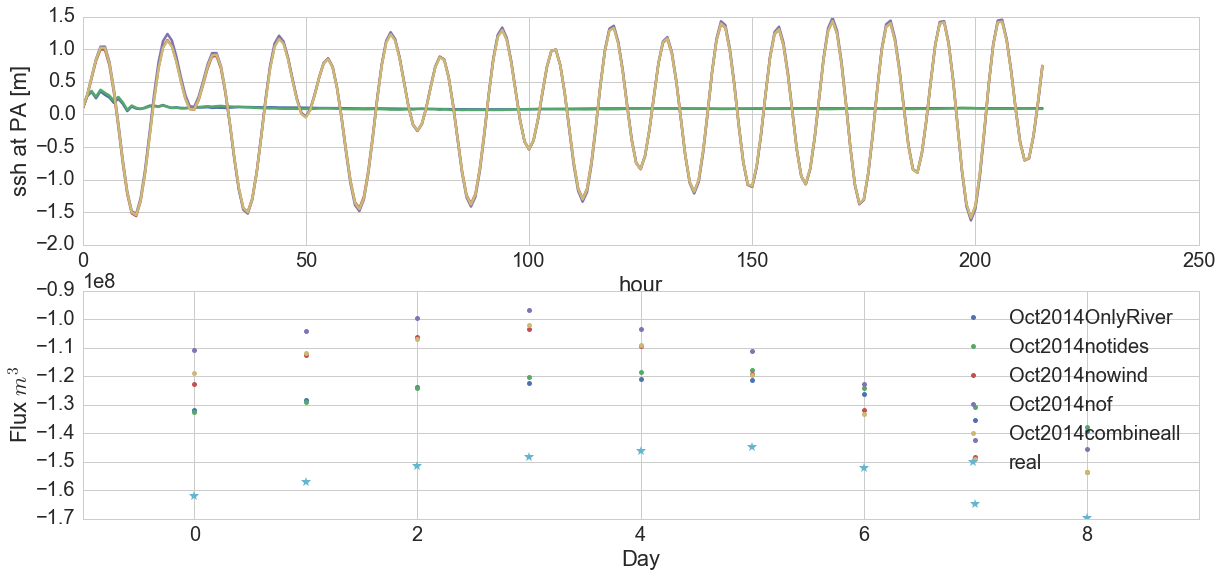

In [13]:
## day 1~ day 9
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'4',0,215,30,data_start =0, fresh_flag='None')

/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d11.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d12.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d13.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d14.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d15.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d16.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d17.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d18.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d19.nc


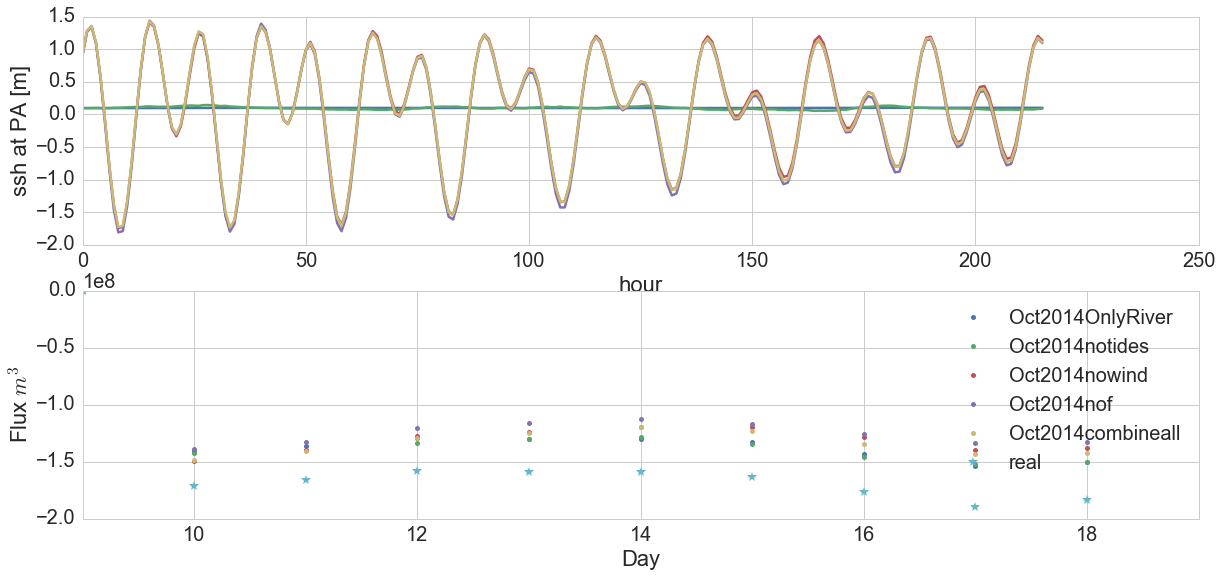

In [12]:
## day 11~ day 19
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'4',240,455,30,data_start =1, fresh_flag='None')

/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d21.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d22.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d23.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d24.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d25.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d26.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d27.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d28.nc


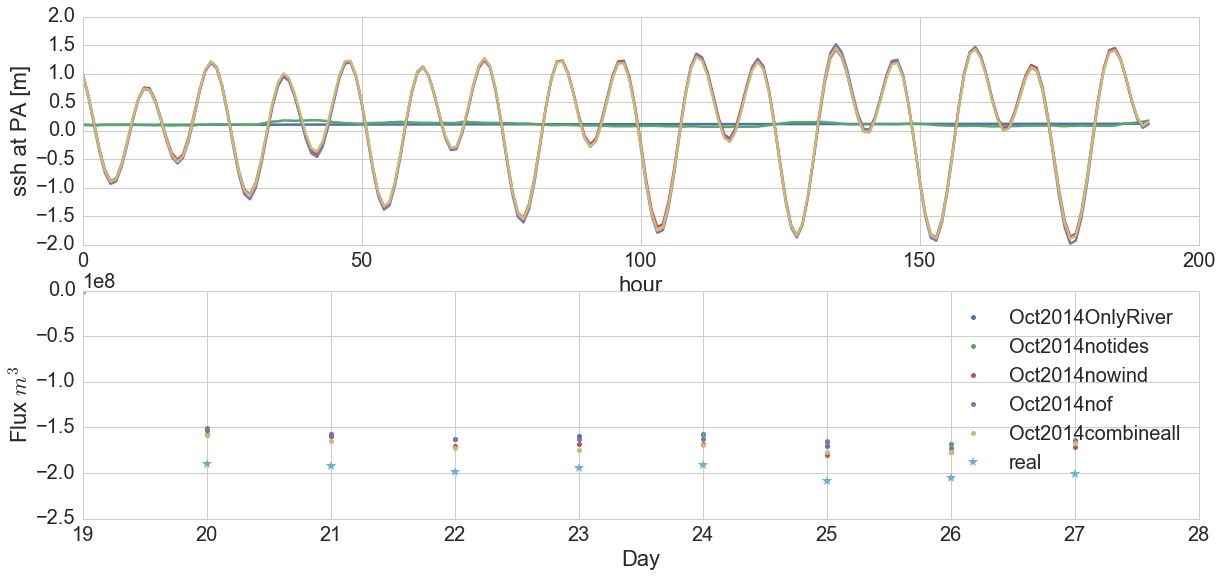

In [15]:
## day 21 ~ day 29
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'4',480,671,30,data_start =2, fresh_flag='None')

* Fresh water transport:
$Q_{fw} = \int {u}\frac{S_{0}-S}{S_{0}}dydz$
for 20 days

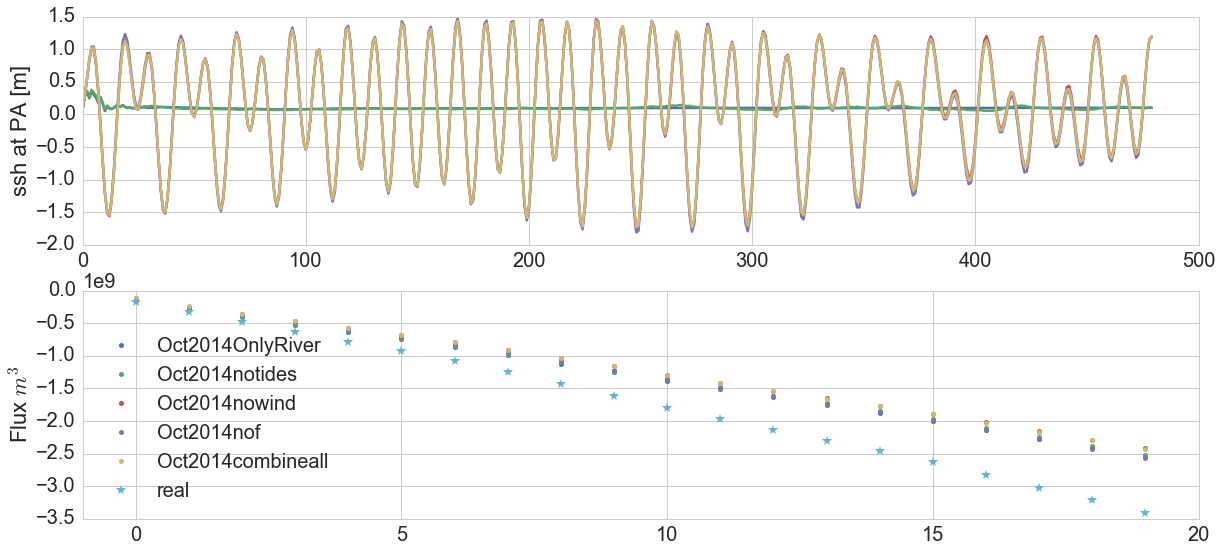

In [10]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,28,fresh_flag='fresh')

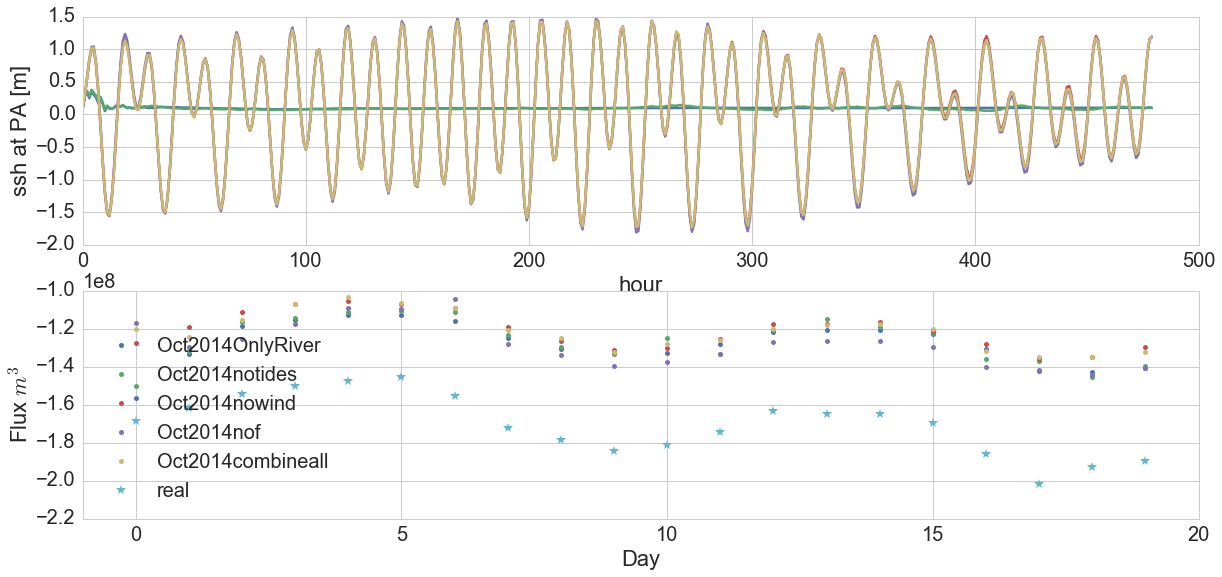

In [11]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,28,fresh_flag='fresh')

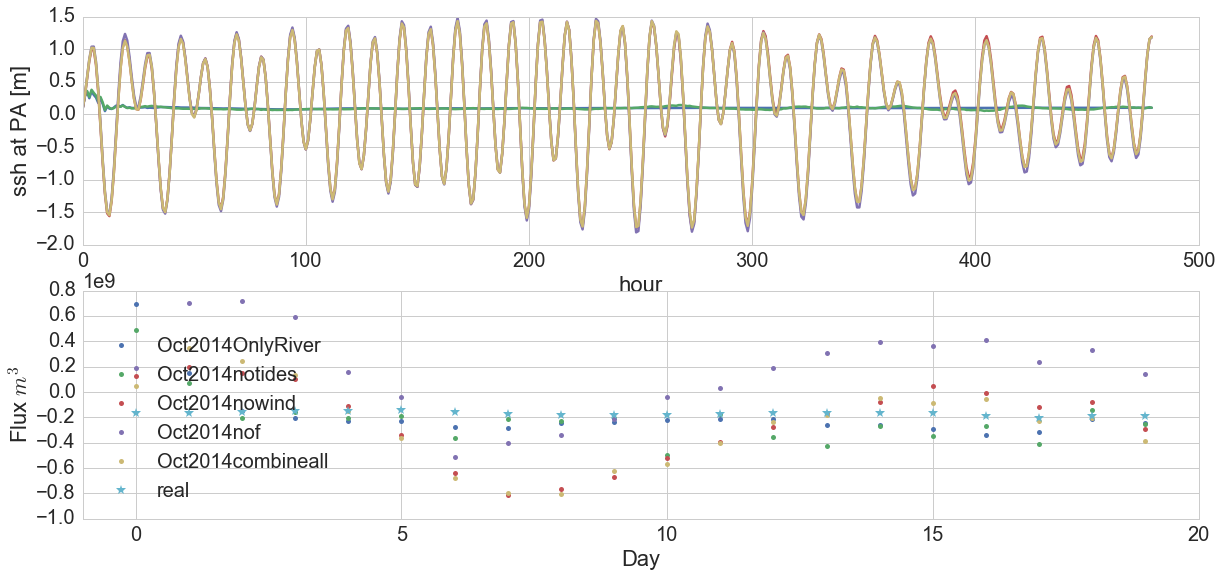

In [12]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,28,fresh_flag='salt')

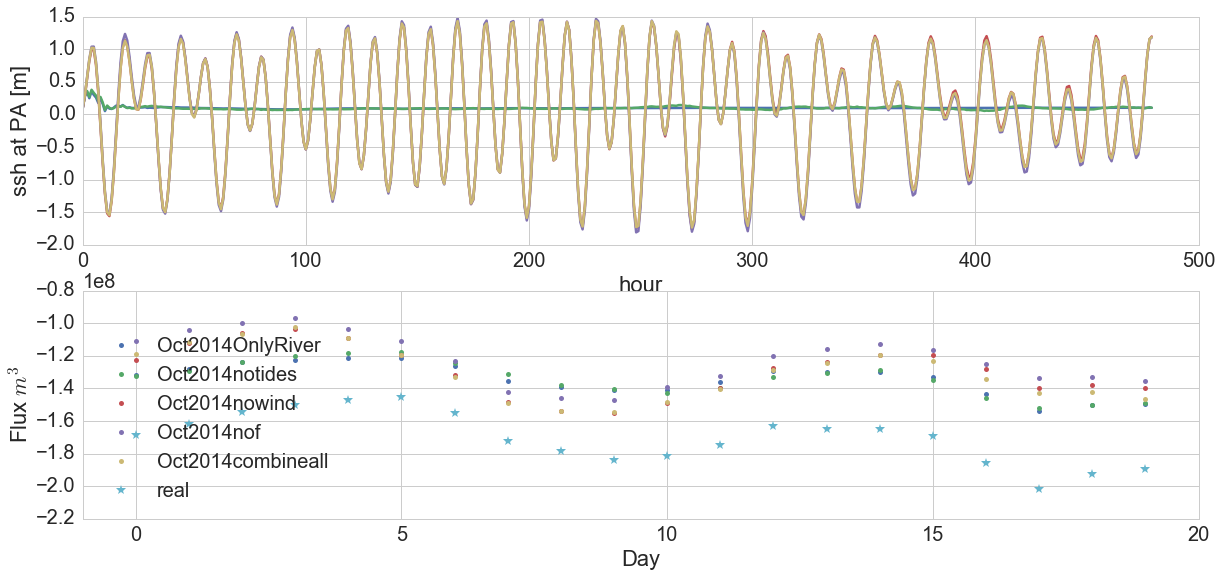

In [13]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,28,fresh_flag='None')

# Choice of $S_{0}$

* Seek the value of $S_{0}$, that results in a total freshwater flux, averaged over the entire 24.8 hr tidal cycle, should equal to the average river discharge during that period.

In [29]:
def seek_So(tst,ten,S_low,S_high,tran):
    '''This function was made to seek the best S0, in terms of 
    total freshwater flux/24hr = averaged river discharge during this period
    The period I select here is one day.'''
    
    types = ['Oct2014OnlyRiver','Oct2014notides','Oct2014nowind','Oct2014nof','Oct2014combineall']
    inte_gral = {}
    for ty in types:
        inte_gral[ty] = []
    for S0 in np.arange(S_low,S_high,1):
        trans,trans_surf,trans_to = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,\
                                                                 S0,fresh_flag = 'fresh')    
        for ty in types:
            inte_gral[ty].append(np.sum(trans_to[ty]*3600)/24) ## for each S0, the fresh water flux
    fig, ax = plt.subplots(1,1,figsize = (16,5))
    filename = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/Fraser_flow'
    fraserflow = np.loadtxt(filename)
    real_flow = np.zeros(S_high-S_low)
    for i in np.arange(S_high-S_low):
        real_flow[i] = -fraserflow[348+tst/24][-1]*3600 # real hourly discharge
    for ty in types:
        ax.plot(inte_gral[ty],'.',markersize = 10,label = ty)
    ax.plot(real_flow,'*',markersize = 10,label = 'real')
    ax.legend(loc = 'best')
    ax.set_xlabel('$S_{0}$ values')
    ax.set_ylabel('averaged hourly fresh water flux $m^{3}hr^{-1}$')
    #ax.set_ylim([-1.15e7,-0.6e7])
    ax.set_xticks(np.arange(S_high-S_low))
    ax.set_xticklabels(np.arange(S_low,S_high))
    return real_flow, inte_gral

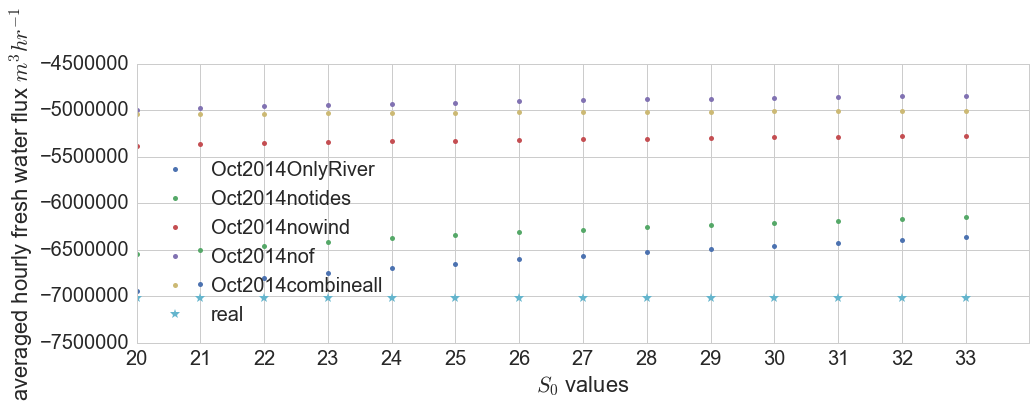

In [30]:
rr,gral = seek_So(0,23,20,34,'4')

# Several other transects inside river channel

*  Transect 5

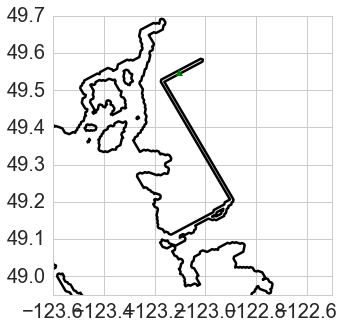

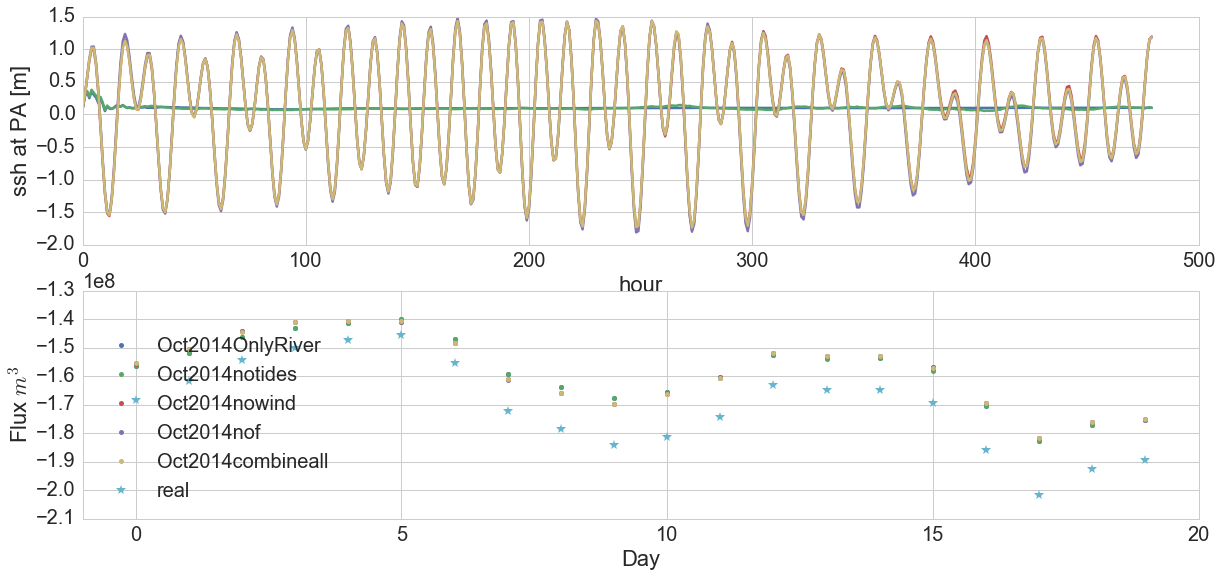

In [20]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
ax.plot(X[120:121,138],Y[120:121,138],'g^')
ax.set_xlim([-123.6,-122.5])
ax.set_ylim([48.95,49.7])
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'5',0,479,28,fresh_flag='fresh')

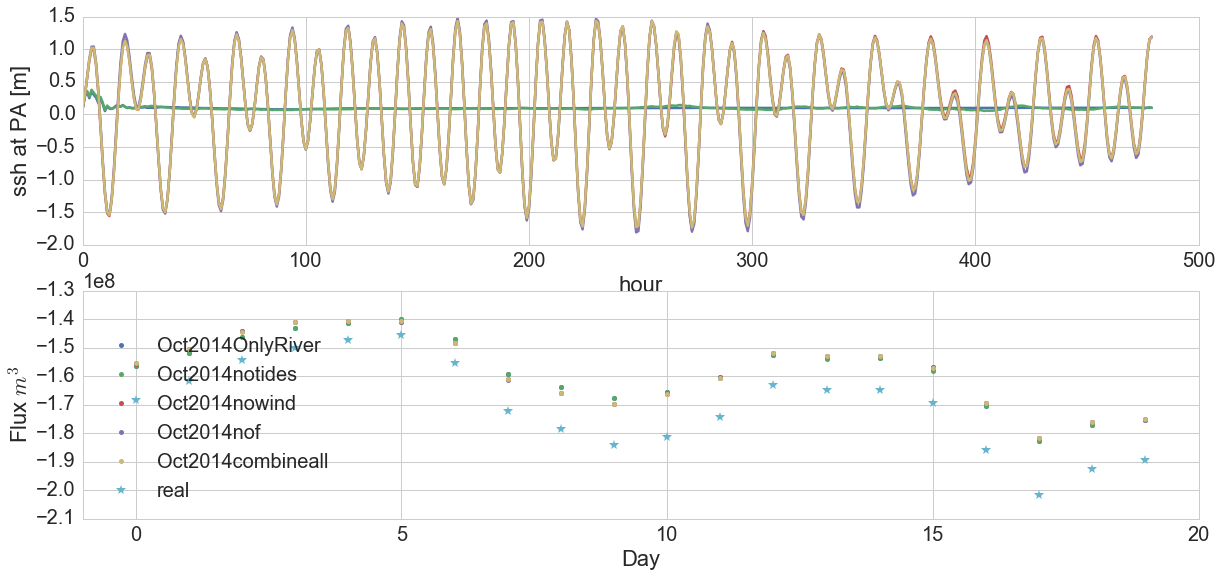

In [21]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'5',0,479,28,fresh_flag='None')

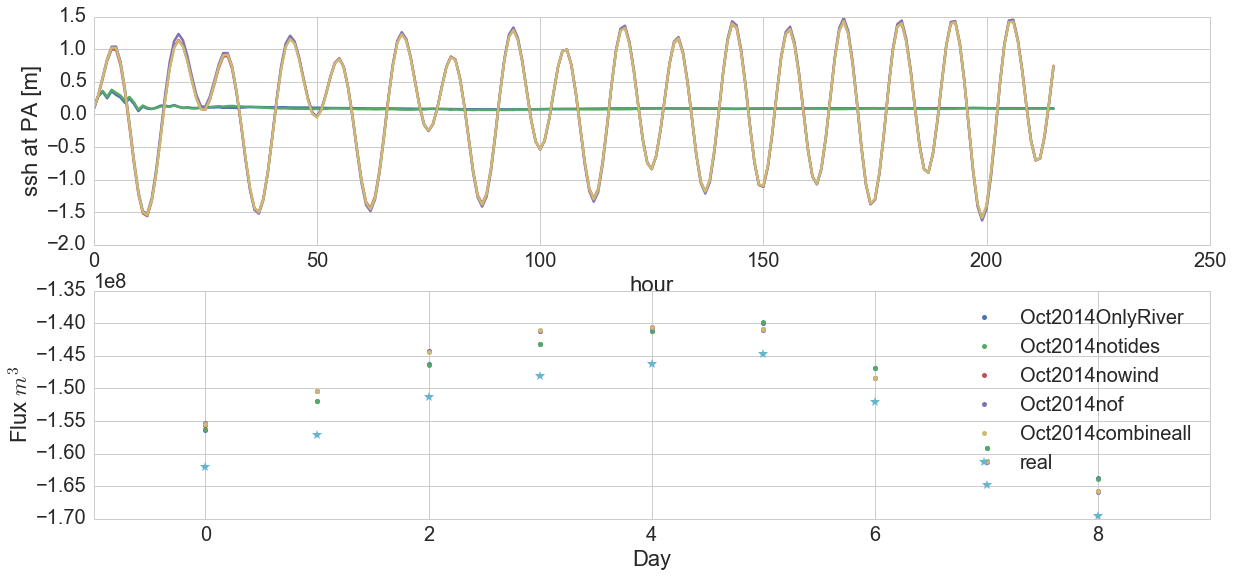

In [16]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'5',0,215,30,string = 1,fresh_flag='None')

* Transect 6

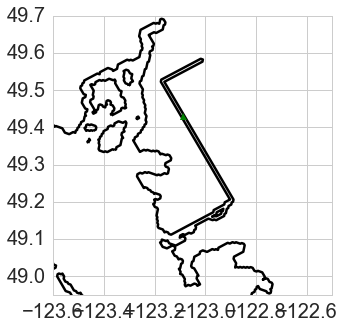

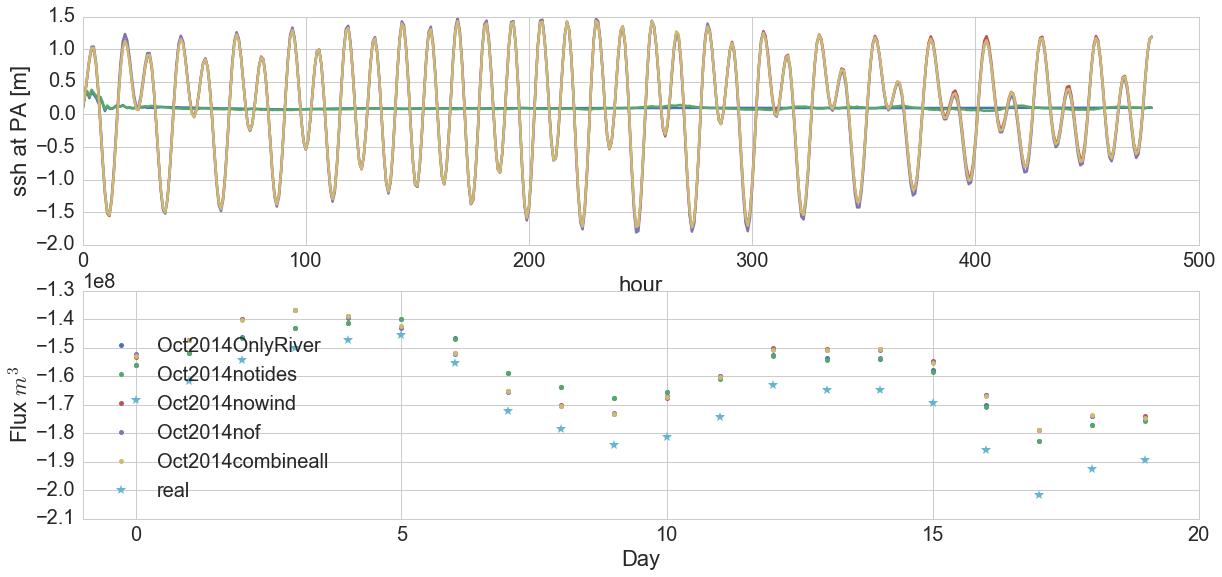

In [22]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
ax.plot(X[96,125:126],Y[96,125:126],'g^')
ax.set_xlim([-123.6,-122.5])
ax.set_ylim([48.95,49.7])
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'6',0,479,28,fresh_flag='fresh')

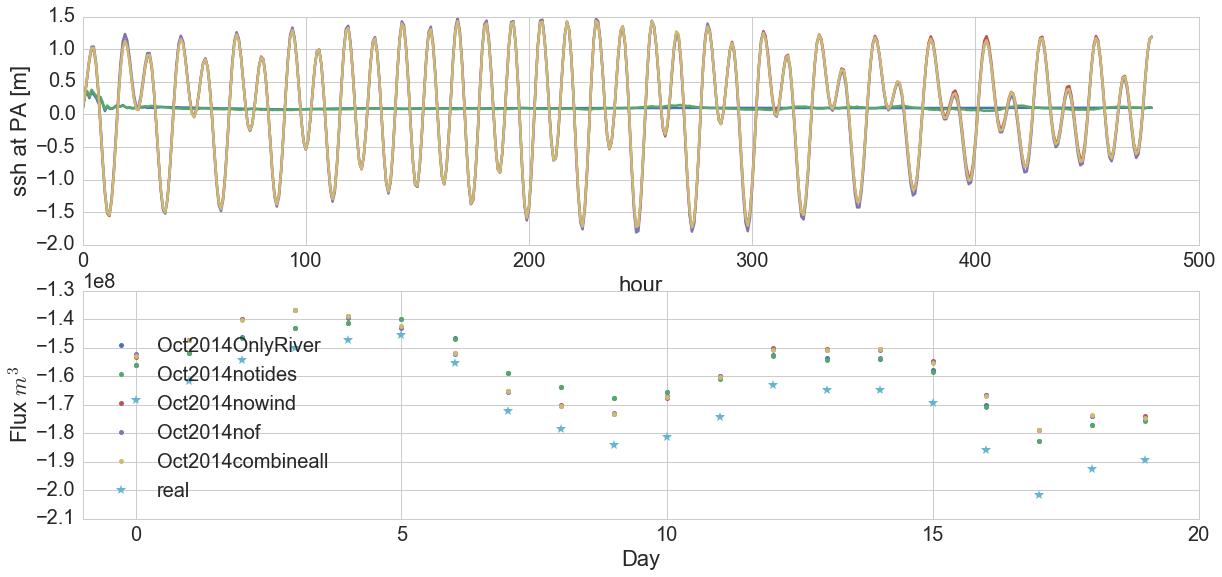

In [23]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'6',0,479,28,fresh_flag='None')

* Transect 7

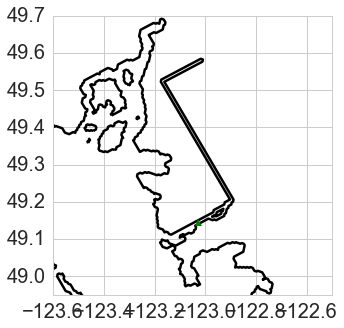

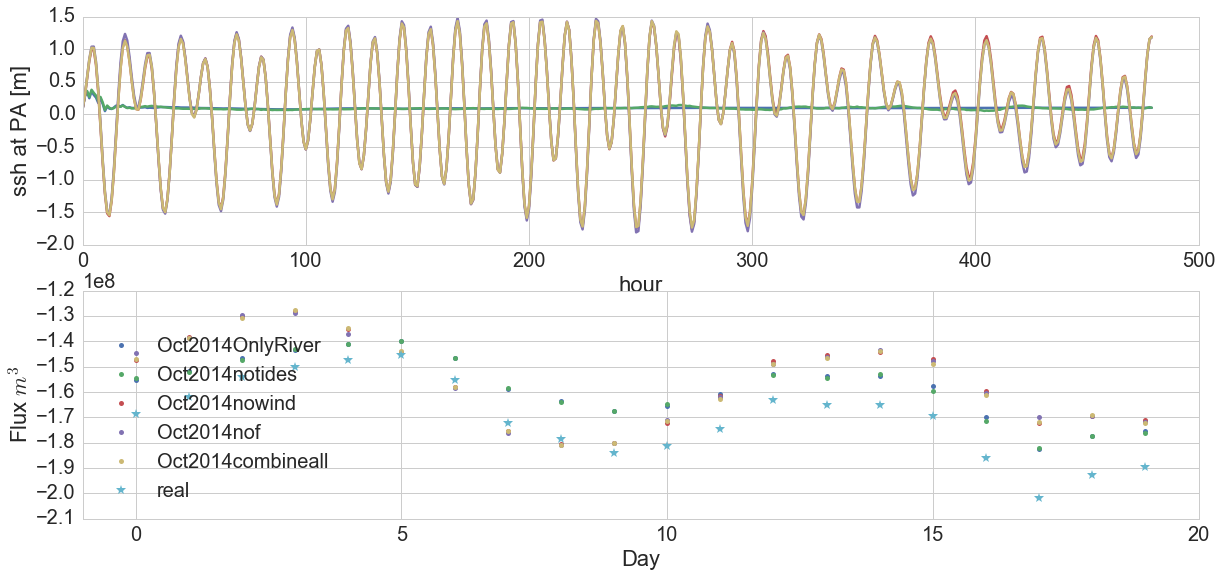

In [39]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
ax.plot(X[36:37,98:99],Y[36:37,98:99],'g^')
ax.set_xlim([-123.6,-122.5])
ax.set_ylim([48.95,49.7])
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'7',0,479,28,fresh_flag='fresh')

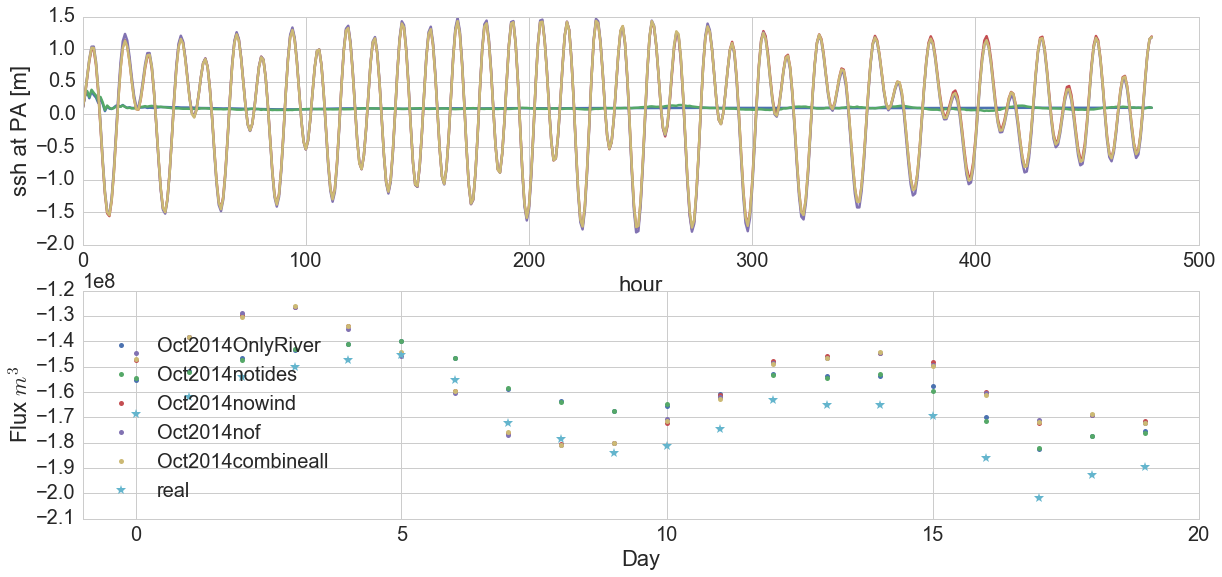

In [40]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'7',0,479,28,fresh_flag='None')

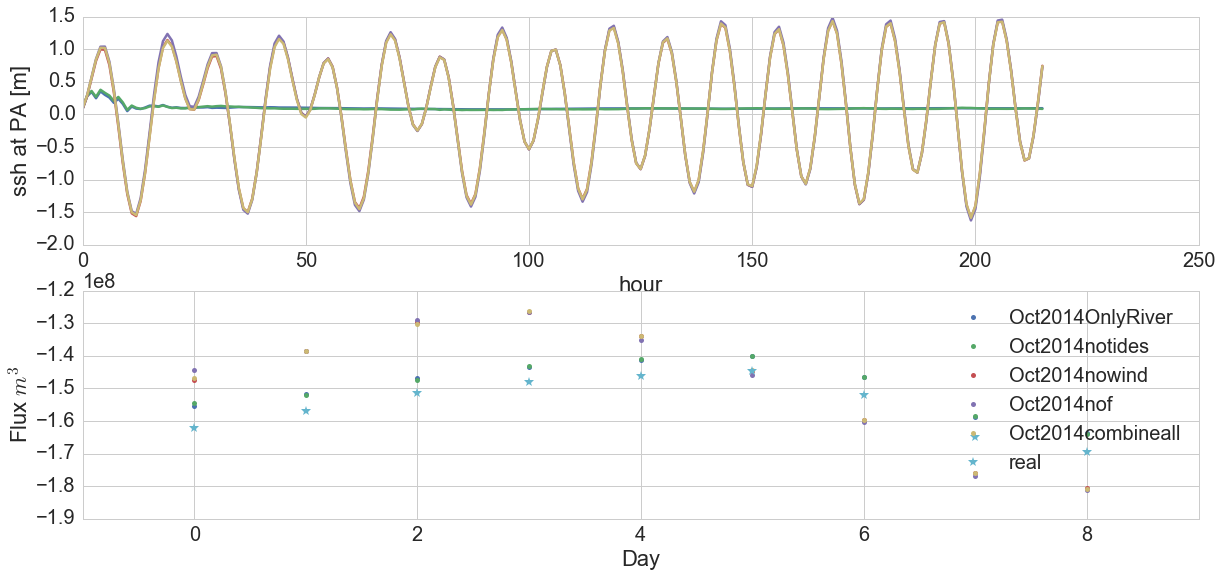

In [15]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'7',0,215,30,string = 1,fresh_flag='None')